# Python Basics


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


csvFileAddress = input('Enter Metatrader5 CSV export File Address:')

DJ = pd.read_csv(csvFileAddress,delim_whitespace=True)

DJ.insert(7, '<ISGREEN>',value=0)
DJ.insert(8, '<SIZE>',value=0)
DJ.insert(9, '<VOLATILITY>',value=0)

DJ['<ISGREEN>'] =  DJ['<CLOSE>'] > DJ['<OPEN>']
DJ['<SIZE>'] =  DJ['<CLOSE>'] - DJ['<OPEN>']
DJ['<VOLATILITY>'] =  DJ['<HIGH>'] - DJ['<LOW>']

DJ.drop(['<VOL>','<SPREAD>'],axis=1,inplace=True)



In [57]:
timeFrame = (int(DJ.iloc[1][1][1])-int(DJ.iloc[0][1][1]) ) * 60 + (int(DJ.iloc[1][1][3:5])-int(DJ.iloc[0][1][3:5]))
CandlesInDay = 24 * (60//timeFrame)

In [58]:
def candleToTime(j):
    minuteMult = CandlesInDay//24
    k=j//minuteMult
    sth=timeFrame*(j%minuteMult)
    return '{:02d}:{:02d}:00'.format(k,sth)

uniqueDays = DJ.drop_duplicates(subset='<DATE>')
uniqueDays = pd.DataFrame(uniqueDays)

uniqueDaysCount=uniqueDays.shape[0]


newDF = pd.DataFrame(columns=['<DATE>','<TIME>'])




for i in range(uniqueDaysCount):

    if(i%(uniqueDaysCount//10)==0):
        print((int((i)/uniqueDaysCount*10000))/100 , '%')
    for j in range(CandlesInDay):
        newDF.loc[(i*CandlesInDay)+j]=[uniqueDays.iloc[i][0],candleToTime(j)]


0.0 %
9.67 %
19.35 %
29.03 %
38.7 %
48.38 %
58.06 %
67.74 %
77.41 %
87.09 %
96.77 %


In [59]:

newestDF = newDF.merge(DJ,on=['<DATE>','<TIME>'],how='left')

# newestDF.drop(columns=['<OPEN>_x','<CLOSE>_x','<SIZE>_x','<VOLATILITY>_x','<ISGREEN>_x'],inplace=True)
newestDF.fillna(0,inplace=True)
newestDF['<EMA30>']= newestDF['<CLOSE>'].ewm(span=30).mean()


In [60]:
newestDF.head(10)

,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<ISGREEN>,<SIZE>,<VOLATILITY>,<EMA30>
0,2021.11.08,00:00:00,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.000000
1,2021.11.08,01:00:00,36348.0,36356.0,36312.0,36319.0,507.0,False,-29.0,44.0,18764.816667
2,2021.11.08,02:00:00,36319.0,36331.0,36291.0,36306.0,1164.0,False,-13.0,40.0,25005.867086
3,2021.11.08,03:00:00,36306.0,36335.0,36275.0,36294.0,1178.0,False,-12.0,60.0,28116.159055
4,2021.11.08,04:00:00,36294.0,36322.0,36290.0,36313.0,786.0,True,19.0,32.0,29981.138824
5,2021.11.08,05:00:00,36313.0,36319.0,36300.0,36304.0,552.0,False,-9.0,19.0,31218.107012
6,2021.11.08,06:00:00,36304.0,36306.0,36289.0,36298.0,468.0,False,-6.0,17.0,32096.707599
7,2021.11.08,07:00:00,36299.0,36323.0,36292.0,36317.0,679.0,True,18.0,31.0,32755.224804
8,2021.11.08,08:00:00,36317.0,36329.0,36303.0,36305.0,630.0,False,-12.0,26.0,33262.675463
9,2021.11.08,09:00:00,36304.0,36336.0,36295.0,36321.0,854.0,True,17.0,41.0,33668.073696


In [61]:
list = []
for i in range(len(newestDF)):
    date = newestDF.iloc[i]["<DATE>"]
    time = newestDF.iloc[i]["<TIME>"]
    isGreen = newestDF.iloc[i]["<ISGREEN>"]
    size = newestDF.iloc[i]["<SIZE>"]
    volatility = newestDF.iloc[i]["<VOLATILITY>"]
    
    list.append([date, time, isGreen, size, volatility])


In [62]:
days = []
for i in range(uniqueDaysCount): 
    days.append(list[i*CandlesInDay: CandlesInDay*(i+1)])


In [63]:
avgMultiplier = float(input('Only calculate candles bigger than X times the average (def=1) :' )or '1')

def eachDayMatrix(day):
    
    avgCandleBodySize=0
    avgCandleVolatility=0

    for i in range(len(day)):
        avgCandleBodySize+=abs(day[i][3])
        avgCandleVolatility+=abs(day[i][4])
    
    avgCandleBodySize/=len(day)
    avgCandleVolatility/=len(day)

    ansMatrix = np.zeros((CandlesInDay,CandlesInDay),dtype=int)
    countMatrix = np.zeros((CandlesInDay,CandlesInDay),dtype=int)
    for i in range(len(day)) : 
        for j in range (i,len(day)):
            if abs(day[i][4])> avgCandleVolatility*avgMultiplier and abs(day[j][4])>0 :
                countMatrix[i][j] += 1
                ansMatrix[i][j]=1 if not(day[i][2] ^ day[j][2]) else -1
                continue
            ansMatrix[i][j]=0
            

    return [ansMatrix,countMatrix]

ansVector = []
countVector = []
for i in range(len(days)):
    countVector.append(eachDayMatrix(days[i])[1])
    ansVector.append(eachDayMatrix(days[i])[0])

final = np.sum(ansVector, axis=0)
countFinal = np.sum(countVector, axis=0)
# final-=len(days)//2
# plt.imshow(final)



<AxesSubplot:>

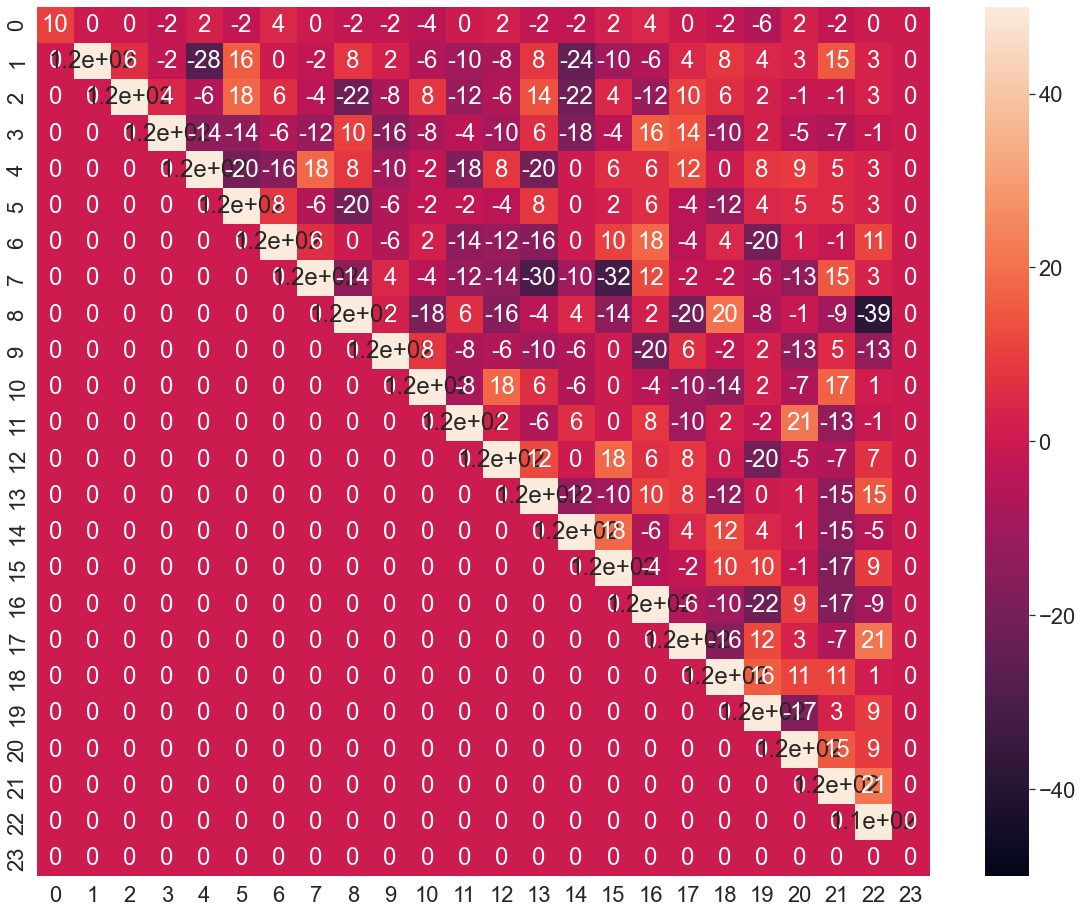

In [64]:
plt.figure(figsize=(20,16))
sns.set(font_scale=2)
sns.heatmap(final,annot=True,vmax=50,vmin=-50)



<AxesSubplot:>

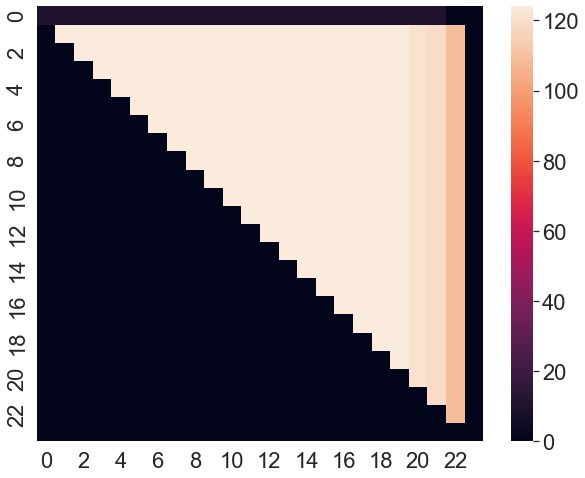

In [65]:
plt.figure(figsize=(10,8))

sns.heatmap(countFinal,annot=False,)


In [66]:
# float(input('Bias:')) 
biasPercentage = 70


consecutiveAndClose = False
consecutiveOnly = False

percentTimesCountedAtLeastMoreThan = 30

print('Averages Multiplier :',avgMultiplier)
for i in range(len(final)):
    for j in range (i,len(final)):
        percentageHigherThanAvg = int(countFinal[i][j]/uniqueDaysCount *10000) /100
        if( percentageHigherThanAvg < percentTimesCountedAtLeastMoreThan ):
            continue
        prob = int(abs(final[i][j]) / countFinal[i][j] *10000)/100 + 50.00
        if (biasPercentage<prob<100)and (not i==j):
            if(j-i==1):

                print(f"{i}-{j}",
                f"{candleToTime(i)}-{candleToTime(j)}",
                f"{prob}% ++",
                percentageHigherThanAvg,
                'Consecutive') if final[i][j]>=0 else print(f"{i}-{j}",
                f"{candleToTime(i)}-{candleToTime(j)}",
                f"{prob}% --",
                percentageHigherThanAvg,
                'Consecutive')
                continue

            if(j-i <= 120/timeFrame) and (not consecutiveOnly):

                print(f"{i}-{j}",
                f"{candleToTime(i)}-{candleToTime(j)}",
                f"{prob}% ++",
                percentageHigherThanAvg,
                'Close') if final[i][j]>=0 else print(f"{i}-{j}",
                f"{candleToTime(i)}-{candleToTime(j)}",
                f"{prob}% --",
                percentageHigherThanAvg,
                'Close')
                continue

            if not(consecutiveAndClose or consecutiveOnly): 
                
                print(f"{i}-{j}",
                f"{candleToTime(i)}-{candleToTime(j)}",
                f"{prob}% ++",
                percentageHigherThanAvg) if final[i][j]>=0 else print(f"{i}-{j}",
                f"{candleToTime(i)}-{candleToTime(j)}",
                f"{prob}% --",
                percentageHigherThanAvg)




Averages Multiplier : 0.0
1-4 01:00:00-04:00:00 72.58% -- 100.0
7-13 07:00:00-13:00:00 74.19% -- 100.0
7-15 07:00:00-15:00:00 75.8% -- 100.0
8-22 08:00:00-22:00:00 85.77000000000001% -- 87.9
